<h1>
<font color=Green> Assignment : Model Experimentation</font>
</h1>

<hr>

<h2>
<font color=Green>Import the Requisite Libraries:</font>
</h2>

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

<hr>
<h2>
<font color=Green>Data Reading:</font>
</h2>

In [3]:
%%time

##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('data/cleaned_data.csv')

CPU times: total: 46.9 ms
Wall time: 68.3 ms


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 01:38:17,3.0,Level3,Level0,Level0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 02:41:36,1.0,Level0,Level11,others,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 03:25:23,1.0,Level3,Level0,others,3.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 03:43:23,3.0,Level3,Level0,others,2.0,0.0,1,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 03:43:29,1.0,Level3,Level0,others,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24977 entries, 0 to 24976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_tier               24977 non-null  float64
 1   first_platform_c        24977 non-null  object 
 2   first_utm_medium_c      24977 non-null  object 
 3   first_utm_source_c      24977 non-null  object 
 4   total_leads_droppped    24977 non-null  float64
 5   referred_lead           24977 non-null  float64
 6   app_complete_flag       24977 non-null  int64  
 7   assistance_interaction  24977 non-null  float64
 8   career_interaction      24977 non-null  float64
 9   payment_interaction     24977 non-null  float64
 10  social_interaction      24977 non-null  float64
 11  syllabus_interaction    24977 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
# Convert the `city_tier` as categorical type variable, since it was categorical originally
dataset['city_tier'] = dataset.city_tier.astype('category')

<hr>
<h2>
<font color=Green>Set up Database: </font>
</h2>

In [14]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("lead_scoring_model_experimentation.db")

2.6.0


In [15]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [16]:
mlflow.set_experiment('Lead_scoring_mlflow_experimentation')

<hr>
<h2>
<font color=Green>Model Experimentation with pycaret: </font>
</h2>

In [21]:
# setup pycaret 
exp_lead_scoring = setup(data=dataset, target = 'app_complete_flag',
                         fold_shuffle=True, 
                         session_id = 42,
                         normalize = True, 
                         transformation = True, 
                         remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                         n_jobs=-1,use_gpu=True,
                         log_experiment=True,experiment_name='Lead_scoring_model_experimentation',
                         log_plots=True, log_data=True,
                         silent=True, verbose=True,
                         log_profile=False)


,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24977, 12)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


2023/01/18 15:13:33 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [22]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 10, exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7128,0.7935,0.7695,0.6912,0.7281,0.4255,0.4284,1.5680
rf,Random Forest Classifier,0.7047,0.7866,0.7457,0.6894,0.7163,0.4094,0.4109,1.4300
et,Extra Trees Classifier,0.7024,0.7837,0.7346,0.6904,0.7117,0.4048,0.4058,1.0670
dt,Decision Tree Classifier,0.7018,0.7828,0.7335,0.6901,0.7110,0.4036,0.4046,0.0570
lr,Logistic Regression,0.6869,0.7656,0.7739,0.6593,0.7120,0.3738,0.3796,0.6390
ridge,Ridge Classifier,0.6868,0.0000,0.7702,0.6603,0.7110,0.3737,0.3790,0.0370
lda,Linear Discriminant Analysis,0.6867,0.7646,0.7701,0.6602,0.7109,0.3734,0.3788,0.1670
nb,Naive Bayes,0.6115,0.7177,0.9822,0.5641,0.7166,0.2229,0.3319,0.0290


In [23]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7210,0.8009,0.7929,0.6930,0.7396,0.4420,0.4467
1,0.7107,0.7875,0.7691,0.6888,0.7268,0.4213,0.4242
2,0.6958,0.7843,0.7657,0.6720,0.7158,0.3916,0.3955
3,0.7065,0.7907,0.7735,0.6821,0.7249,0.4130,0.4168
4,0.7271,0.8110,0.7826,0.7044,0.7415,0.4542,0.4571
5,0.7002,0.7793,0.7346,0.6874,0.7102,0.4005,0.4014
6,0.7162,0.7935,0.7620,0.6981,0.7287,0.4325,0.4343
7,0.7031,0.7882,0.7380,0.6898,0.7131,0.4062,0.4072
8,0.7414,0.8245,0.7929,0.7189,0.7541,0.4828,0.4854


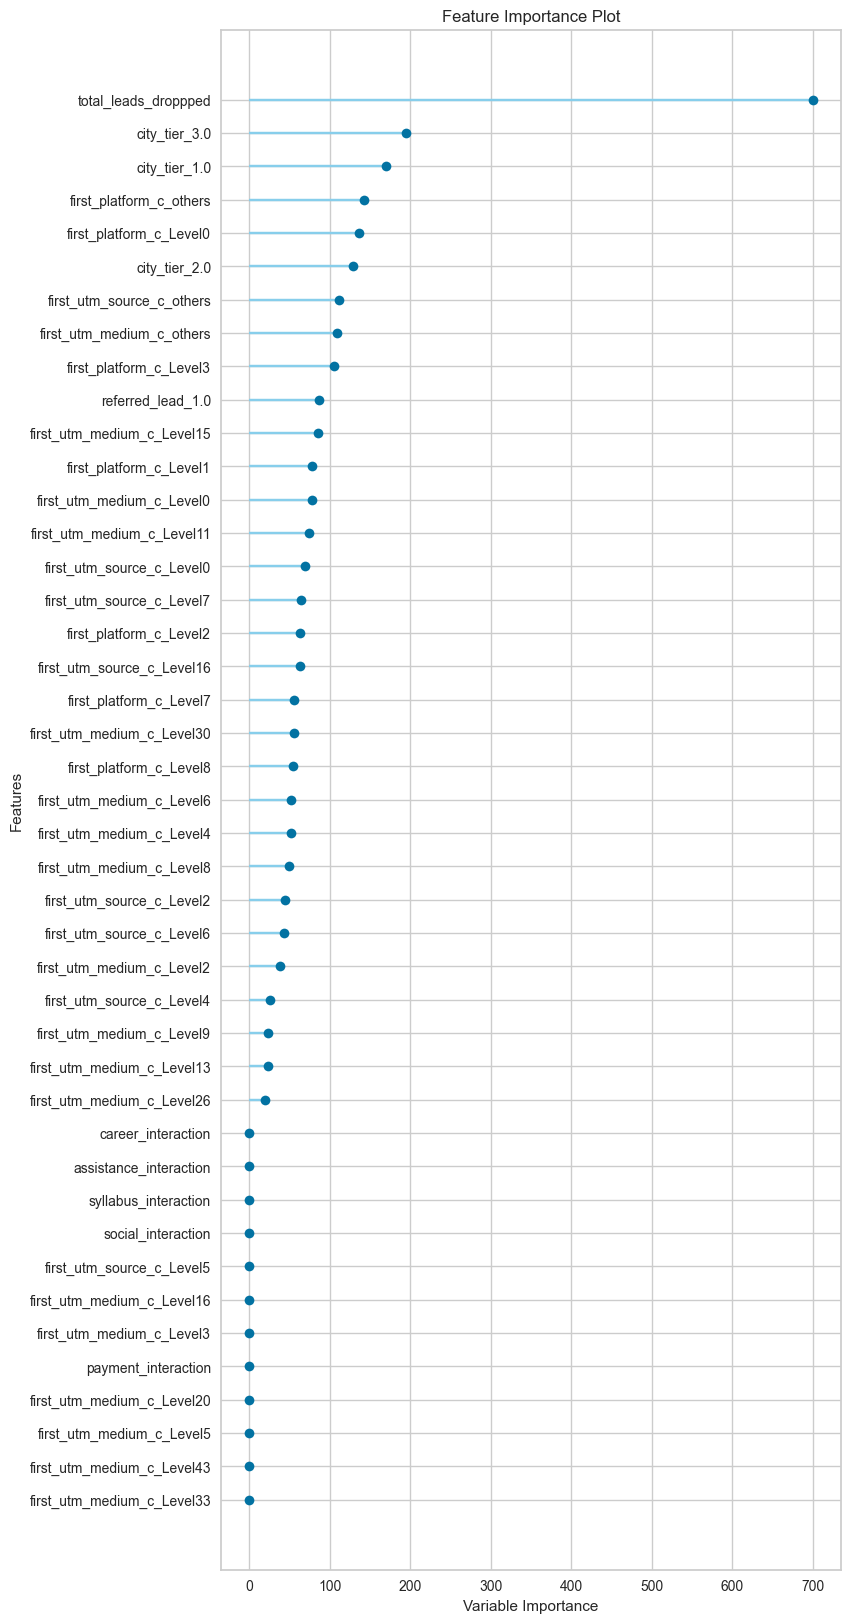

In [24]:
# create feature importance plot
plot_model(lightgbm, plot='feature_all')

In [25]:
# list of the features that needs to be there in the final encoded dataframe
ONE_HOT_ENCODED_FEATURES = ['total_leads_droppped', 'city_tier_3.0',
                            'city_tier_1.0','first_platform_c_Level0',
                            'city_tier_2.0', 'first_platform_c_others',
                            'first_utm_source_c_others', 'first_utm_medium_c_others',
                            'first_platform_c_Level3', 'referred_lead',
                            'first_platform_c_Level1', 'first_utm_medium_c_Level15',
                            'first_utm_medium_c_Level0', 'first_utm_medium_c_Level11',
                            'first_utm_source_c_Level0', 'first_utm_source_c_Level7',
                            'first_platform_c_Level2', 'first_utm_source_c_Level16',
                            'first_utm_medium_c_Level30', 'first_platform_c_Level7',
                            'first_platform_c_Level8', 'first_utm_medium_c_Level6',
                            'first_utm_medium_c_Level4', 'first_utm_medium_c_Level8',
                            'first_utm_source_c_Level2', 'first_utm_source_c_Level6',
                            'first_utm_medium_c_Level2', 'first_utm_source_c_Level4',
                            'first_utm_medium_c_Level9', 'first_utm_medium_c_Level3',
                            'first_utm_medium_c_Level26', 'app_complete_flag']

In [26]:
FEATURES_TO_ENCODE = ['city_tier', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']

In [27]:
df_encoded = pd.DataFrame(columns=ONE_HOT_ENCODED_FEATURES)
df_placeholder = pd.DataFrame()

In [28]:
# encode the features using get_dummies()
for f in FEATURES_TO_ENCODE:
    if(f in dataset.columns):
        encoded = pd.get_dummies(dataset[f])
        encoded = encoded.add_prefix(f + '_')
        df_placeholder = pd.concat([df_placeholder, encoded], axis=1)
    else:
        print('Feature not found')

In [29]:
# add the encoded features into a single dataframe
for feature in df_encoded.columns:
    if feature in dataset.columns:
        df_encoded[feature] = dataset[feature]
    if feature in df_placeholder.columns:
        df_encoded[feature] = df_placeholder[feature]
df_encoded.fillna(0, inplace=True)

In [30]:
df_encoded.head()

,total_leads_droppped,city_tier_3.0,city_tier_1.0,first_platform_c_Level0,city_tier_2.0,first_platform_c_others,first_utm_source_c_others,first_utm_medium_c_others,first_platform_c_Level3,referred_lead,...,first_utm_medium_c_Level4,first_utm_medium_c_Level8,first_utm_source_c_Level2,first_utm_source_c_Level6,first_utm_medium_c_Level2,first_utm_source_c_Level4,first_utm_medium_c_Level9,first_utm_medium_c_Level3,first_utm_medium_c_Level26,app_complete_flag
0,2.0,1,0,0,0,0,0,0,1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,1,1,0,0,1,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0,1,0,0,0,1,0,1,0.0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,1,0,0,0,0,1,0,1,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,0,1,0,0,0,1,0,1,0.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24977 entries, 0 to 24976
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_leads_droppped        24977 non-null  float64
 1   city_tier_3.0               24977 non-null  uint8  
 2   city_tier_1.0               24977 non-null  uint8  
 3   first_platform_c_Level0     24977 non-null  uint8  
 4   city_tier_2.0               24977 non-null  uint8  
 5   first_platform_c_others     24977 non-null  uint8  
 6   first_utm_source_c_others   24977 non-null  uint8  
 7   first_utm_medium_c_others   24977 non-null  uint8  
 8   first_platform_c_Level3     24977 non-null  uint8  
 9   referred_lead               24977 non-null  float64
 10  first_platform_c_Level1     24977 non-null  uint8  
 11  first_utm_medium_c_Level15  24977 non-null  uint8  
 12  first_utm_medium_c_Level0   24977 non-null  uint8  
 13  first_utm_medium_c_Level11  249

<hr>
<h2>
<font color=Green>Model Experimentation after dropping features: </font>
</h2>

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

We will drop the following variables
['carrer_interaction'.'assistance_interaction', 'syllabus_interaction', 'social_interaction']

In [34]:
# Setup Pycaret Enviornment with selected variables 
from pycaret.classification import *

exp_lead_scoring = setup(data=df_encoded , target = 'app_complete_flag',  
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   fold_shuffle=True, 
                   session_id = 42,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Lead_scoring_mlflow_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24977, 32)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


2023/01/18 15:15:01 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring_mlflow_experimentation' does not exist. Creating a new experiment.


In [35]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7114,0.7932,0.7656,0.6909,0.7262,0.4228,0.4255,1.5320
rf,Random Forest Classifier,0.7040,0.7868,0.7447,0.6889,0.7156,0.4080,0.4095,1.0780
et,Extra Trees Classifier,0.7018,0.7836,0.7326,0.6903,0.7107,0.4035,0.4044,1.0720
dt,Decision Tree Classifier,0.7010,0.7822,0.7318,0.6897,0.7100,0.4020,0.4029,0.0560
lr,Logistic Regression,0.6850,0.7573,0.7718,0.6578,0.7102,0.3700,0.3758,0.5160
lda,Linear Discriminant Analysis,0.6844,0.7467,0.7680,0.6581,0.7088,0.3688,0.3741,0.1270
ridge,Ridge Classifier,0.6843,0.0000,0.7681,0.6580,0.7088,0.3686,0.3740,0.0370
nb,Naive Bayes,0.6285,0.7127,0.9501,0.5784,0.7190,0.2570,0.3365,0.0280


In [36]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lightgbm_fs = create_model('lightgbm', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7158,0.7994,0.7952,0.6861,0.7366,0.4317,0.4373
1,0.7124,0.7864,0.7703,0.6906,0.7283,0.4248,0.4276
2,0.6975,0.7845,0.7669,0.6737,0.7173,0.3950,0.3989
3,0.7094,0.7918,0.7643,0.6887,0.7245,0.4188,0.4213
4,0.7260,0.8086,0.7712,0.7072,0.7378,0.4519,0.4538
5,0.6991,0.7810,0.7265,0.6887,0.7071,0.3982,0.3988
6,0.7162,0.7932,0.7563,0.7002,0.7272,0.4325,0.4339
7,0.6997,0.7876,0.7346,0.6866,0.7098,0.3993,0.4003
8,0.7426,0.8254,0.7941,0.7199,0.7552,0.4851,0.4877


In [37]:
#!pip install optuna

In [38]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
import optuna

tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_fs, 
                                   search_library = 'optuna',
                                   fold = 5,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.7901,0.7941,0.6817,0.7336,0.4235,0.4294
1,0.7035,0.7878,0.7839,0.6754,0.7256,0.4069,0.4123
2,0.7132,0.7924,0.7810,0.6878,0.7315,0.4263,0.4303
3,0.7054,0.7858,0.7672,0.6828,0.7225,0.4108,0.4139
4,0.7140,0.7987,0.7866,0.6868,0.7333,0.4279,0.4325
Mean,0.7095,0.7910,0.7825,0.6829,0.7293,0.4191,0.4237
Std,0.0043,0.0044,0.0088,0.0044,0.0045,0.0086,0.0087


In [39]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [41]:
# Store the selected data columns DataFrame in the SQL Database
cnx = sqlite3.connect("lead_scoring_model_experimentation.db")

df_encoded.to_sql(name='model_experimentation', con=cnx,if_exists='replace', index=False)
cnx.close()